# Average video quality

The basic example shows how to plot the shaping to average quality level plot from the IFIP Networking 2016 publication.

## Reading the dataset with pandas

Remove warnings and show plots inline:

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Import the required modules:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats

Read the dataset:

In [3]:
data = pd.read_csv("../data/ifip_networking.csv.gz")

Convert the shaping to Mbps:

In [4]:
data.loc[:,'shaping_mbps'] = data.loc[:,'net_avg_shaping_rate']*8/1000/1000
data.loc[:,'shaping_mbps_rounded'] = data.loc[:,'shaping_mbps'].round(1)

## Definitions

Dict for translating itags to quality levels and vice-versa:

In [5]:
ITAG_TO_QL = {160: 0,
              133: 1,
              134: 2,
              135: 3,
              136: 4}
QL_TO_ITAG = {v: k for k, v in ITAG_TO_QL.items()}

VIDDEF = {160: {'label': '144p', 'color': 'green', 'resolution':  '256x144'},
          133: {'label': '240p', 'color': 'red'  , 'resolution':  '320x240'},
          134: {'label': '360p', 'color': 'blue' , 'resolution':  '480x360'},
          135: {'label': '480p', 'color': 'grey' , 'resolution':  '640x480'},
          136: {'label': '720p', 'color': 'cyan' , 'resolution': '1280x720'}}

Confidence Interval:

In [6]:
def confintv_yerr(values):
    n, min_max, mean, var, skew, kurt = scipy.stats.describe(values)
    std = np.sqrt(var)

    intv = scipy.stats.t.interval(0.95,len(values)-1,loc=mean,scale=std/np.sqrt(len(values)))

    yerr = ((intv[1] - intv[0]) / 2)
    
    return yerr

## Plotting shaping to average quality level

The subsequent plot shows the fraction of time the video spent on the a certain quality level and the overall average quality level for a specific network shaping value. For example, at 2.2 Mbps, the player spends nearly 100% of the time on the highest quality level (480p).

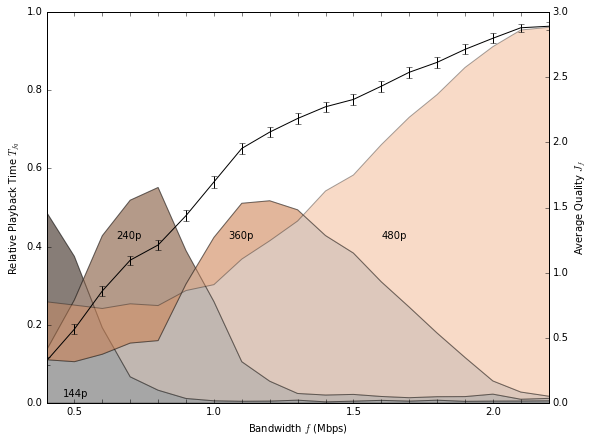

In [7]:
fig = plt.figure(figsize=(9, 7))

plt.hold(True)
ax1 = fig.add_subplot(111)

by_shaping = data.groupby('shaping_mbps').mean()    

y_offset = 0
cmap = plt.get_cmap('copper')
colors = iter(cmap(np.linspace(0,1,len(QL_TO_ITAG))))

for ql,itag in list(QL_TO_ITAG.items())[0:4]:

    idx_itag = 'pl_time_spent_norm_itag%d' % itag
    ax1.fill_between(by_shaping.index, 
                     y_offset,
                     by_shaping[idx_itag],
                     alpha=0.35,
                     facecolor=next(colors))

    y_offset = by_shaping[idx_itag]

plt.annotate(s=VIDDEF[QL_TO_ITAG[0]]['label'], xy=(0.46, 0.014))
plt.annotate(s=VIDDEF[QL_TO_ITAG[1]]['label'], xy=(0.65, 0.42))
plt.annotate(s=VIDDEF[QL_TO_ITAG[2]]['label'], xy=(1.05, 0.42))
plt.annotate(s=VIDDEF[QL_TO_ITAG[3]]['label'], xy=(1.6, 0.42))

plt.ylabel(r"Relative Playback Time $T_{fq}$")
plt.xlabel(r"Bandwidth $f$ (Mbps)")    

ax2 = ax1.twinx()

ax2_data = pd.DataFrame(columns=['shaping', 'avg_ql', 'yerr'])
for shaping,group in data.groupby('shaping_mbps'):

    ql_median = group['pl_avg_pl_quality_ql'].mean()
    ql_yerr = confintv_yerr(group['pl_avg_pl_quality_ql'])

    ax2_data = ax2_data.append(pd.DataFrame([[shaping, ql_median, ql_yerr]], columns=ax2_data.columns))

ax2_data.reset_index(drop=True)

ax2.errorbar(ax2_data['shaping'], ax2_data['avg_ql'], yerr=list(ax2_data['yerr']), color='black')

plt.ylabel(r"Average Quality $J_f$")

max_mbps = 2.2
tl = [""]*int(2.2/0.1)
tl[1] = "0.5"
tl[6] = "1.0"
tl[11] = "1.5"
tl[16] = "2.0"
plt.xticks(np.arange(by_shaping.index.min(), max_mbps, 0.1), tl)

plt.xlim([by_shaping.index.min(), max_mbps])
_ = plt.ylim([0, 3])

---
Export notebook to HTML:

In [8]:
!ipython nbconvert avg_quality.ipynb --to html

[NbConvertApp] Converting notebook avg_quality.ipynb to html
[NbConvertApp] Writing 272454 bytes to avg_quality.html
